In [2]:
import rasterio
import os
import numpy as np
import matplotlib.pyplot as plt
import folium
from rasterio.plot import reshape_as_image
from folium.raster_layers import ImageOverlay
from matplotlib.colors import ListedColormap
from branca.element import Template, MacroElement
from matplotlib import cm
from matplotlib.colors import Normalize
from random import shuffle
import requests
import pandas as pd
from datetime import datetime, timedelta
from itertools import product


In [3]:
# Reading the necessary files.
path = "D:\\Master\\PhD Files\\CourseWorks\\MSE program\\ClassProject"  


# Visualization of land use data

In [ ]:
# === 1. Load the raster ===
with rasterio.open(os.path.join(path,"landuse.tif")) as src:
    land_use = src.read(1)  # Read first band only
    bounds = src.bounds

# === 2. Define land use classes and RGB colors ===
class_colors = {
    0: ('Water', (0, 112, 192)),
    1: ('Trees', (34, 139, 34)),
    2: ('Grass', (124, 252, 0)),
    3: ('Flooded Vegetation', (0, 255, 255)),
    4: ('Crops', (255, 255, 0)),
    5: ('Shrub and Scrub', (160, 82, 45)),
    6: ('Built', (220, 20, 60)),
    7: ('Bare', (210, 180, 140)),
    8: ('Snow and Ice', (255, 250, 250)),
}

# === 3. Create an empty RGB image ===
height, width = land_use.shape
rgb = np.zeros((height, width, 3), dtype=np.uint8)

# === 4. Map class values to RGB channels ===
for class_val, (_, color) in class_colors.items():
    mask = (land_use == class_val)
    rgb[mask] = color  # This works since color is a 3-tuple (R, G, B)

# === 5. Create folium map ===
center = [(bounds.top + bounds.bottom) / 2, (bounds.left + bounds.right) / 2]
m = folium.Map(location=center, zoom_start=12, tiles='CartoDB positron')

img_overlay = ImageOverlay(
    image=rgb,
    bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
    opacity=0.6,
    name='Land Use',
)

img_overlay.add_to(m)
folium.LayerControl().add_to(m)

# === 6. Custom legend ===
legend_html = """
{% macro html(this, kwargs) %}
<div style="position: fixed;
     bottom: 20px; left: 20px; width: 200px; height: auto;
     z-index:9999; font-size:14px;
     background-color: white;
     border:2px solid grey; border-radius:6px;
     padding: 10px;">
<h4>Land Use Legend</h4>
<ul style="list-style: none; padding: 0; margin: 0;">
""" + "".join([
    f'<li><span style="background-color: rgb{rgb}; width: 12px; height: 12px; display: inline-block; margin-right: 8px;"></span>{label}</li>'
    for label, rgb in [class_colors[i] for i in sorted(class_colors)]
]) + """
</ul>
</div>
{% endmacro %}
"""

legend = MacroElement()
legend._template = Template(legend_html)
m.get_root().add_child(legend)

# === 7. Save the map ===
#m.save('land_use_map_with_legend.html')

m


# Visualization of NDVI

In [ ]:
# === 1. Load NDVI raster ===
with rasterio.open(os.path.join(path, "NDVI.tif")) as src:
    ndvi = src.read(1)
    bounds = src.bounds

# === 2. Normalize NDVI to 0–255 and apply colormap ===
# Clip out invalid NDVI values
ndvi = np.clip(ndvi, -1, 1)

# Normalize to 0–1
norm = Normalize(vmin=-1, vmax=1)
ndvi_normalized = norm(ndvi)

# Use matplotlib colormap (RdYlGn is common for NDVI)
colormap = cm.get_cmap('RdYlGn')

# Apply colormap and convert to 8-bit RGB
rgba_img = colormap(ndvi_normalized)
rgb_img = (rgba_img[:, :, :3] * 255).astype(np.uint8)  # Drop alpha channel

# === 3. Create folium map ===
center = [(bounds.top + bounds.bottom) / 2, (bounds.left + bounds.right) / 2]
m = folium.Map(location=center, zoom_start=12, tiles='CartoDB positron')

# === 4. Add NDVI overlay ===
img_overlay = ImageOverlay(
    image=rgb_img,
    bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
    opacity=0.6,
    name='NDVI'
)

img_overlay.add_to(m)
folium.LayerControl().add_to(m)

# === 5. Show map in notebook ===

legend_html = """
{% macro html(this, kwargs) %}
<div style="position: fixed; bottom: 20px; left: 20px; width: 140px; background-color: white;
     border:2px solid grey; z-index:9999; font-size:14px; padding: 10px; border-radius: 6px;">
<b>NDVI Legend</b><br>
<div style="background: linear-gradient(to right, brown, yellow, green); height: 10px;"></div>
<span style="float: left;">-1</span>
<span style="float: right;">1</span>
</div>
{% endmacro %}
"""

legend = MacroElement()
legend._template = Template(legend_html)
m.get_root().add_child(legend)

m


# Visualization of Slopes

In [ ]:


# === 1. Load slope raster ===
with rasterio.open(os.path.join(path, "SlopeExport.tif")) as src:
    slope = src.read(1).astype('float32')  # Ensure float type for math
    nodata = src.nodata
    bounds = src.bounds

# === 2. Mask nodata / NaN areas ===
# If nodata value exists, mask it; otherwise, use NaN mask
if nodata is not None:
    mask = slope != nodata
else:
    mask = ~np.isnan(slope)

# === 3. Normalize slope for visualization ===
valid_slope = slope[mask]
vmin = valid_slope.min()
vmax = valid_slope.max()

norm = Normalize(vmin=vmin, vmax=vmax)
colormap = cm.get_cmap('terrain')  # Try 'viridis', 'plasma', etc.

# === 4. Apply colormap to valid slope pixels ===
rgba = colormap(norm(valid_slope))[:, :3]  # Drop alpha
rgb_img = np.zeros((slope.shape[0], slope.shape[1], 3), dtype=np.uint8)

for i in range(3):
    channel = (rgba[:, i] * 255).astype(np.uint8)
    rgb_img[:, :, i][mask] = channel

# === 5. Create folium map ===
center = [(bounds.top + bounds.bottom) / 2, (bounds.left + bounds.right) / 2]
m = folium.Map(location=center, zoom_start=12, tiles='CartoDB positron')

# Add image overlay
img_overlay = ImageOverlay(
    image=rgb_img,
    bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
    opacity=0.7,
    name='Slope (degrees)'
)
img_overlay.add_to(m)
folium.LayerControl().add_to(m)

# === 6. Display in notebook ===

legend_html = """
{{% macro html(this, kwargs) %}}
<div style="position: fixed;
     bottom: 20px; left: 20px; width: 160px; background-color: white;
     border:2px solid grey; z-index:9999; font-size:14px; padding: 10px; border-radius: 6px;">
<b>Slope (°)</b><br>
<div style="background: linear-gradient(to right, #e0e0e0, #a1dab4, #41b6c4, #225ea8);
     height: 10px; margin-bottom: 5px;"></div>
<span style="float: left;">{vmin:.1f}°</span>
<span style="float: right;">{vmax:.1f}°</span>
</div>
{{% endmacro %}}
""".format(vmin=vmin, vmax=vmax)

legend = MacroElement()
legend._template = Template(legend_html)
m.get_root().add_child(legend)

m

In [ ]:
# Fuel Factors based flammability of the specific land use and Alexandridis et al., 2008
fuel_to_factor = {
    4: -0.3,   # Agriculture
    2: 0.0,    # Thickets (Shrub/Grassland)
    1: 0.4,    # Trees (Forest)
    7: -0.4,   # Bare soil (minimal to no fuel)
    6: -0.6,   # Built area (generally non-flammable or fire breaks)
    3: -0.2,   # Flooded vegetation (reduced burn potential)
    5: 0.0,    # Shrub/Grassland
    8: -0.8    # Snow/Ice (non-burnable)
}

In [5]:
EMPTY = 0       # No vegetation
VEGETATION = 1  # Vegetation present (fuel)
BURNING = 9     # Actively burning
BURNED = 10      # Completely burned

In [ ]:
# Define Moore Neighborhood (8 neighbors)
NEIGHBORHOOD = [(-1, -1), (-1, 0), (-1, 1),
                (0, -1),          (0, 1),
                (1, -1),  (1, 0), (1, 1)]

# Fire Spread Constants & Environmental Parameters
P0 = 0.58   # Base probability of fire spread
C1 = 0.045  # Wind speed coefficient
C2 = 0.131  # Wind direction coefficient
A = 0.078   # Elevation coefficient

In [ ]:
# Fire Simulation Functions
# This will be replaced with an actual ignition model

def ignite_fire(grid, ignition_point):
    x, y = ignition_point
    grid[x, y] = BURNING
    return grid




In [ ]:
# Calculation of fire propagation probability

def calculate_fire_probability(p0, p_veg_factor, wind_speed, wind_dir, terrain_slope, fire_dir, p_den):
    theta = np.cos(np.deg2rad(abs(wind_dir - fire_dir)))
    P_w = np.exp(C1 * wind_speed) * np.exp(C2 * wind_speed * (theta - 1))
    P_ele = np.exp(A * terrain_slope)
    return p0 * (1 + p_veg_factor)*(1 + p_den) * P_w * P_ele

In [ ]:
# Visulation function

def plot_grid(grid, step):
    colors = {
        0: ('Water', (0, 112, 192)),    # water // medium Blue
        1: ('Trees', (34, 139, 34)),     # tree/vegetation // Green
        2: ('Grass', (124, 252, 0)),  # grass // Bright Lime Green
        3: ('Flooded Vegetation',(0, 255, 255)), # Flooded Vegetation // Cyan
        4: ('Crops', (255, 255, 0)), # crop // Bright Yellow
        5: ('Shrub and Scrub', (160, 82, 45)), # Shrub and Scrub // Saddle Brown
        6: ('Built', (220, 20, 60)), # Built // Crimson
        7: ('Bare', (210, 180, 140)), # Bare // Tan
        8: ('Snow and Ice', (255, 250, 250)), # Snow and ICE // Bery Light Pinkish White
        9: ('Burning', (57, 255, 20)), # Burning // vivide Magneta / Hot Pink(fire)
        10: ('Burned', (10, 10, 60)) # Burned // Charcoal Purple
    }
    height, width = grid.shape
    
    rgb = np.zeros((height, width,3), dtype=np.uint8)
    for class_val, (_, color) in colors.items():
        mask = (grid == class_val)
        rgb[mask] = color
        
    plt.imshow(rgb)
    plt.title(f"Fire Spread - Step {step}")
    plt.axis('off')
    plt.show()

In [ ]:
#Function to download wind data from open meteo via api

def fetch_wind_data(lat, lon, hours=48):
    """
    Fetch hourly wind speed and direction from Open-Meteo API.
    Returns a pandas DataFrame with columns: time, wind_speed, wind_direction
    """
    # Time range: now to now + hours
    start_time = datetime.utcnow()
    end_time = start_time + timedelta(hours=hours)

    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": "wind_speed_10m,wind_direction_10m",
        "start_date": start_time.strftime("%Y-%m-%d"),
        "end_date": end_time.strftime("%Y-%m-%d"),
        "timezone": "UTC"
    }

    response = requests.get(url, params=params)
    data = response.json()

    df = pd.DataFrame({
        "time": data["hourly"]["time"],
        "wind_speed": data["hourly"]["wind_speed_10m"],
        "wind_direction": data["hourly"]["wind_direction_10m"]
    })

    df["time"] = pd.to_datetime(df["time"])

    return df

In [18]:
def get_wind_conditions_from_df(df_wind, step, interval_minutes=60):
    """
    Retrieve wind speed and direction for the current step based on the DataFrame.
    Assumes 1 step = interval_minutes (e.g., 60 mins).
    """
    idx = min(step, len(df_wind) - 1)
    row = df_wind.iloc[idx]
    return row["wind_speed"], row["wind_direction"]

In [12]:
def interpolate_wind(df_hourly, freq='5min'):
    """
    Interpolate wind speed and direction from hourly to 5-minute intervals.
    """
    df = df_hourly.copy()
    df = df.set_index('time')
    df_resampled = df.resample(freq).interpolate(method='linear')
    df_resampled = df_resampled.reset_index()
    return df_resampled

In [ ]:
#This function the simulation run wiate for 3 steps before burining cells are updated to burned cells
#This also includes random propagation of the wildfire outside the confined parameters after 11 steps.

def sim_actualdata(landusepath, nadvipath, slopepath, output, steps = 20):
    with rasterio.open(landusepath) as landuse:
        land_use = landuse.read(1)  # Read first band only
        meta_ = landuse.meta
        center_row = landuse.height //2
        center_col = landuse.width //2
        lon, lat = landuse.transform * (center_col, center_row)

        df_hourly = fetch_wind_data(lat, lon, hours=24)
        df_5min = interpolate_wind(df_hourly, freq='5min')

        
        
        with rasterio.open(nadvipath) as ndvisrc:
            ndvi = ndvisrc.read(1)
            ndvi = np.where((ndvi < -1)|(ndvi >1), -999, ndvi)
        
        with rasterio.open(slopepath) as slopesrc:
            slope = slopesrc.read(1)
            
        newlanduse = np.where(np.isnan(land_use), -999, land_use)
        
        landusegrid = np.where(newlanduse == 0, EMPTY, newlanduse)
        
        grid_size = landusegrid.shape
        
        ignition_point = (grid_size[0]//2, grid_size[1]//2)  #will replace this with actual model
        
        landusegrid = ignite_fire(landusegrid, ignition_point)
        
            
        rows, cols = landusegrid.shape
        burn_age = np.zeros_like(landusegrid)
        
        for step in range(steps):
            wind_speed, wind_direction = get_wind_conditions_from_df(df_5min, step) 
            new_grid = landusegrid.copy()
            for x in range(1, rows-1):
                for y in range(1, cols-1):
                    if landusegrid[x, y] == BURNING:
                        burn_age[x, y] += 1
                        
                    #if landusegrid[x,y] == BURNING:
                        #Burn out the current cell
                        #new_grid[x,y] = BURNED
                        
                        #Check all 8 neighbors
                        
                        if burn_age[x,y] == 1:
                            continue
                        if burn_age[x,y] < 3:
                            
                            direction = NEIGHBORHOOD[:]
                            
                            shuffle(direction)
                            for dx, dy in direction:
                                nx, ny = x + dx, y + dy
                                
                                if landusegrid[nx,ny] not in (BURNING, BURNED, EMPTY, -999):
                                    fuel_type = newlanduse[nx,ny]
                                    fuel_factor = fuel_to_factor.get(fuel_type, 0)
                                    fire_dir = np.degrees(np.arctan2(dy,dx))
                                    
                                    p_burn = calculate_fire_probability(P0, fuel_factor, wind_speed, wind_direction, slope[nx,ny], fire_dir, ndvi[nx,ny])
                                    if np.random.rand() < p_burn:
                                        new_grid[nx, ny] = BURNING
                                        
                            if step <11 and np.random.rand() < 0.01:
                                sx = min(max(x + np.random.randint(-10,10),1),landusegrid.shape[0]-2)
                                sy = min(max(y + np.random.randint(-10,10),1),landusegrid.shape[1]-2)
                                if landusegrid[sx,sy] not in (BURNING, BURNED, EMPTY, -999):
                                     fuel_type = newlanduse[sx,sy]
                                     if fuel_to_factor.get(fuel_type, -1) > -0.6:
                                         new_grid[sx, sy] = BURNING       
                        else:
                            new_grid[x, y] = BURNED
                            
            landusegrid = new_grid.copy()
            if step in [100, 200,300, 400,500]:
                with rasterio.open(os.path.join(output,f"simraster{step}.tif"), "w", **meta_) as dest:
                    dest.write(landusegrid,1)

In [ ]:
#This uses the base model. Burning cells are updated at each step.


def sim_actualdata(landusepath, nadvipath, slopepath, output, steps = 20):
    with rasterio.open(landusepath) as landuse:
        land_use = landuse.read(1)  # Read first band only
        meta_ = landuse.meta
        center_row = landuse.height //2
        center_col = landuse.width //2
        lon, lat = landuse.transform * (center_col, center_row)

        df_hourly = fetch_wind_data(lat, lon, hours=24)
        df_5min = interpolate_wind(df_hourly, freq='5min')

        
        
        with rasterio.open(nadvipath) as ndvisrc:
            ndvi = ndvisrc.read(1)
            ndvi = np.where((ndvi < -1)|(ndvi >1), -999, ndvi)
        
        with rasterio.open(slopepath) as slopesrc:
            slope = slopesrc.read(1)
            
        newlanduse = np.where(np.isnan(land_use), -999, land_use)
        
        landusegrid = np.where(newlanduse == 0, EMPTY, newlanduse)
        
        grid_size = landusegrid.shape
        
        ignition_point = (grid_size[0]//2, grid_size[1]//2)  #will replace this with actual model
        
        landusegrid = ignite_fire(landusegrid, ignition_point)
        
            
        rows, cols = landusegrid.shape        
        for step in range(steps):
            wind_speed, wind_direction = get_wind_conditions_from_df(df_5min, step) 
            new_grid = landusegrid.copy()
            for x in range(1, rows-1):
                for y in range(1, cols-1):
                    if landusegrid[x,y] == BURNING:
                        #Burn out the current cell
                        new_grid[x,y] = BURNED
                        
                        #Check all 8 neighbors
                        for dx, dy in NEIGHBORHOOD:
                            nx, ny = x + dx, y + dy

                                
                            if landusegrid[nx,ny] not in (BURNING, BURNED, EMPTY, -999):
                                fuel_type = newlanduse[nx,ny]
                                fuel_factor = fuel_to_factor.get(fuel_type, 0)
                                fire_dir = np.degrees(np.arctan2(dy,dx))
                                    
                                p_burn = calculate_fire_probability(P0, fuel_factor, wind_speed, wind_direction, slope[nx,ny], fire_dir, ndvi[nx,ny])
                                if np.random.rand() < p_burn:
                                    new_grid[nx, ny] = BURNING
                            
            landusegrid = new_grid.copy()
            if step in [100, 200,300, 400,500]:
                with rasterio.open(os.path.join(output,f"simraster{step}_.tif"), "w", **meta_) as dest:
                    dest.write(landusegrid,1)

In [23]:

landusepath = os.path.join(path,"landuse.tif")

NDVIpath = os.path.join(path, "NDVI.tif")

slopepath = os.path.join(os.path.join(path, "SlopeExport.tif"))

outpath = path

sim_actualdata(landusepath, NDVIpath, slopepath, outpath, steps = 501)

C:\Users\cod\AppData\Local\Temp\ipykernel_24112\754439564.py:7: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  start_time = datetime.utcnow()



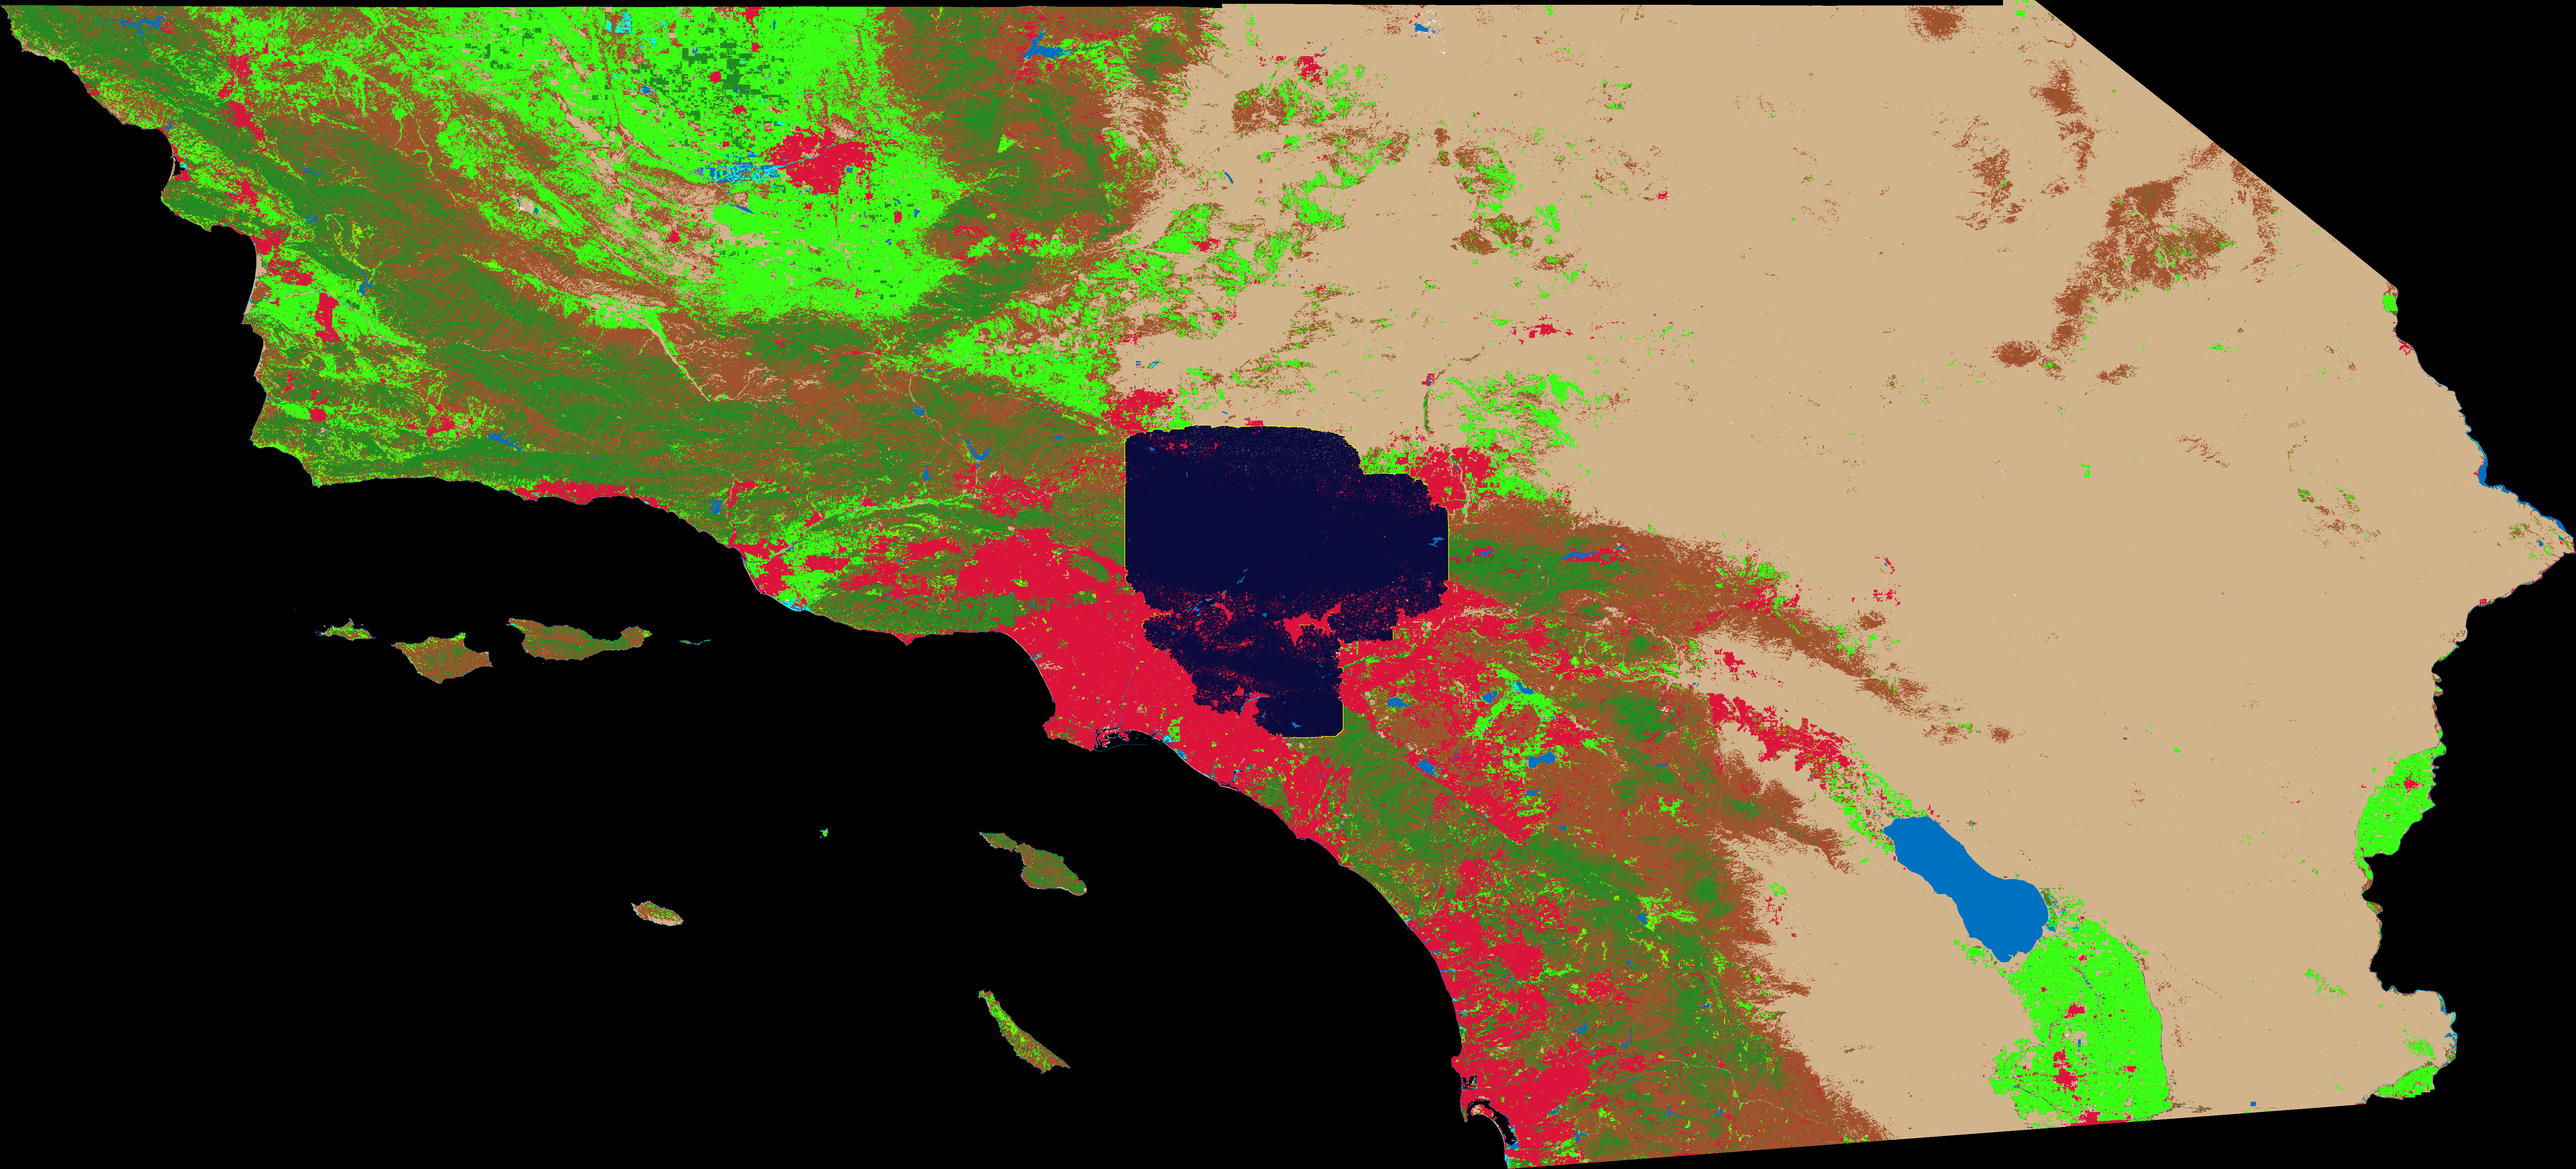

In [19]:
# === 1. Load the raster ===
with rasterio.open(os.path.join(path,"simraster500.tif")) as src:
    land_use = src.read(1)  # Read first band only
    bounds = src.bounds
    
    land_use = np.where(land_use == -999, np.nan, land_use)

# === 2. Define land use classes and RGB colors ===
class_colors = {
    0: ('Water', (0, 112, 192)),
    1: ('Trees', (34, 139, 34)),
    2: ('Grass', (124, 252, 0)),
    3: ('Flooded Vegetation', (0, 255, 255)),
    4: ('Crops', (57, 255, 20)),
    5: ('Shrub and Scrub', (160, 82, 45)),
    6: ('Built', (220, 20, 60)),
    7: ('Bare', (210, 180, 140)),
    8: ('Snow and Ice', (255, 250, 250)),
    9: ('Burning', (255, 255, 0)),
    10: ('Burned', (10, 10, 60))
}

# === 3. Create an empty RGB image ===
height, width = land_use.shape
rgb = np.zeros((height, width, 3), dtype=np.uint8)

# === 4. Map class values to RGB channels ===
for class_val, (_, color) in class_colors.items():
    mask = (land_use == class_val)
    rgb[mask] = color  # This works since color is a 3-tuple (R, G, B)

# === 5. Create folium map ===
center = [(bounds.top + bounds.bottom) / 2, (bounds.left + bounds.right) / 2]
m = folium.Map(location=center, zoom_start=12, tiles='CartoDB positron')

img_overlay = ImageOverlay(
    image=rgb,
    bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
    opacity=0.6,
    name='Land Use',
)

img_overlay.add_to(m)
folium.LayerControl().add_to(m)

# === 6. Custom legend ===
legend_html = """
{% macro html(this, kwargs) %}
<div style="position: fixed;
     bottom: 20px; left: 20px; width: 200px; height: auto;
     z-index:9999; font-size:14px;
     background-color: white;
     border:2px solid grey; border-radius:6px;
     padding: 10px;">
<h4>Land Use Legend</h4>
<ul style="list-style: none; padding: 0; margin: 0;">
""" + "".join([
    f'<li><span style="background-color: rgb{rgb}; width: 12px; height: 12px; display: inline-block; margin-right: 8px;"></span>{label}</li>'
    for label, rgb in [class_colors[i] for i in sorted(class_colors)]
]) + """
</ul>
</div>
{% endmacro %}
"""

legend = MacroElement()
legend._template = Template(legend_html)
m.get_root().add_child(legend)

# === 7. Save the map ===
#m.save('land_use_map_with_legend.html')

m



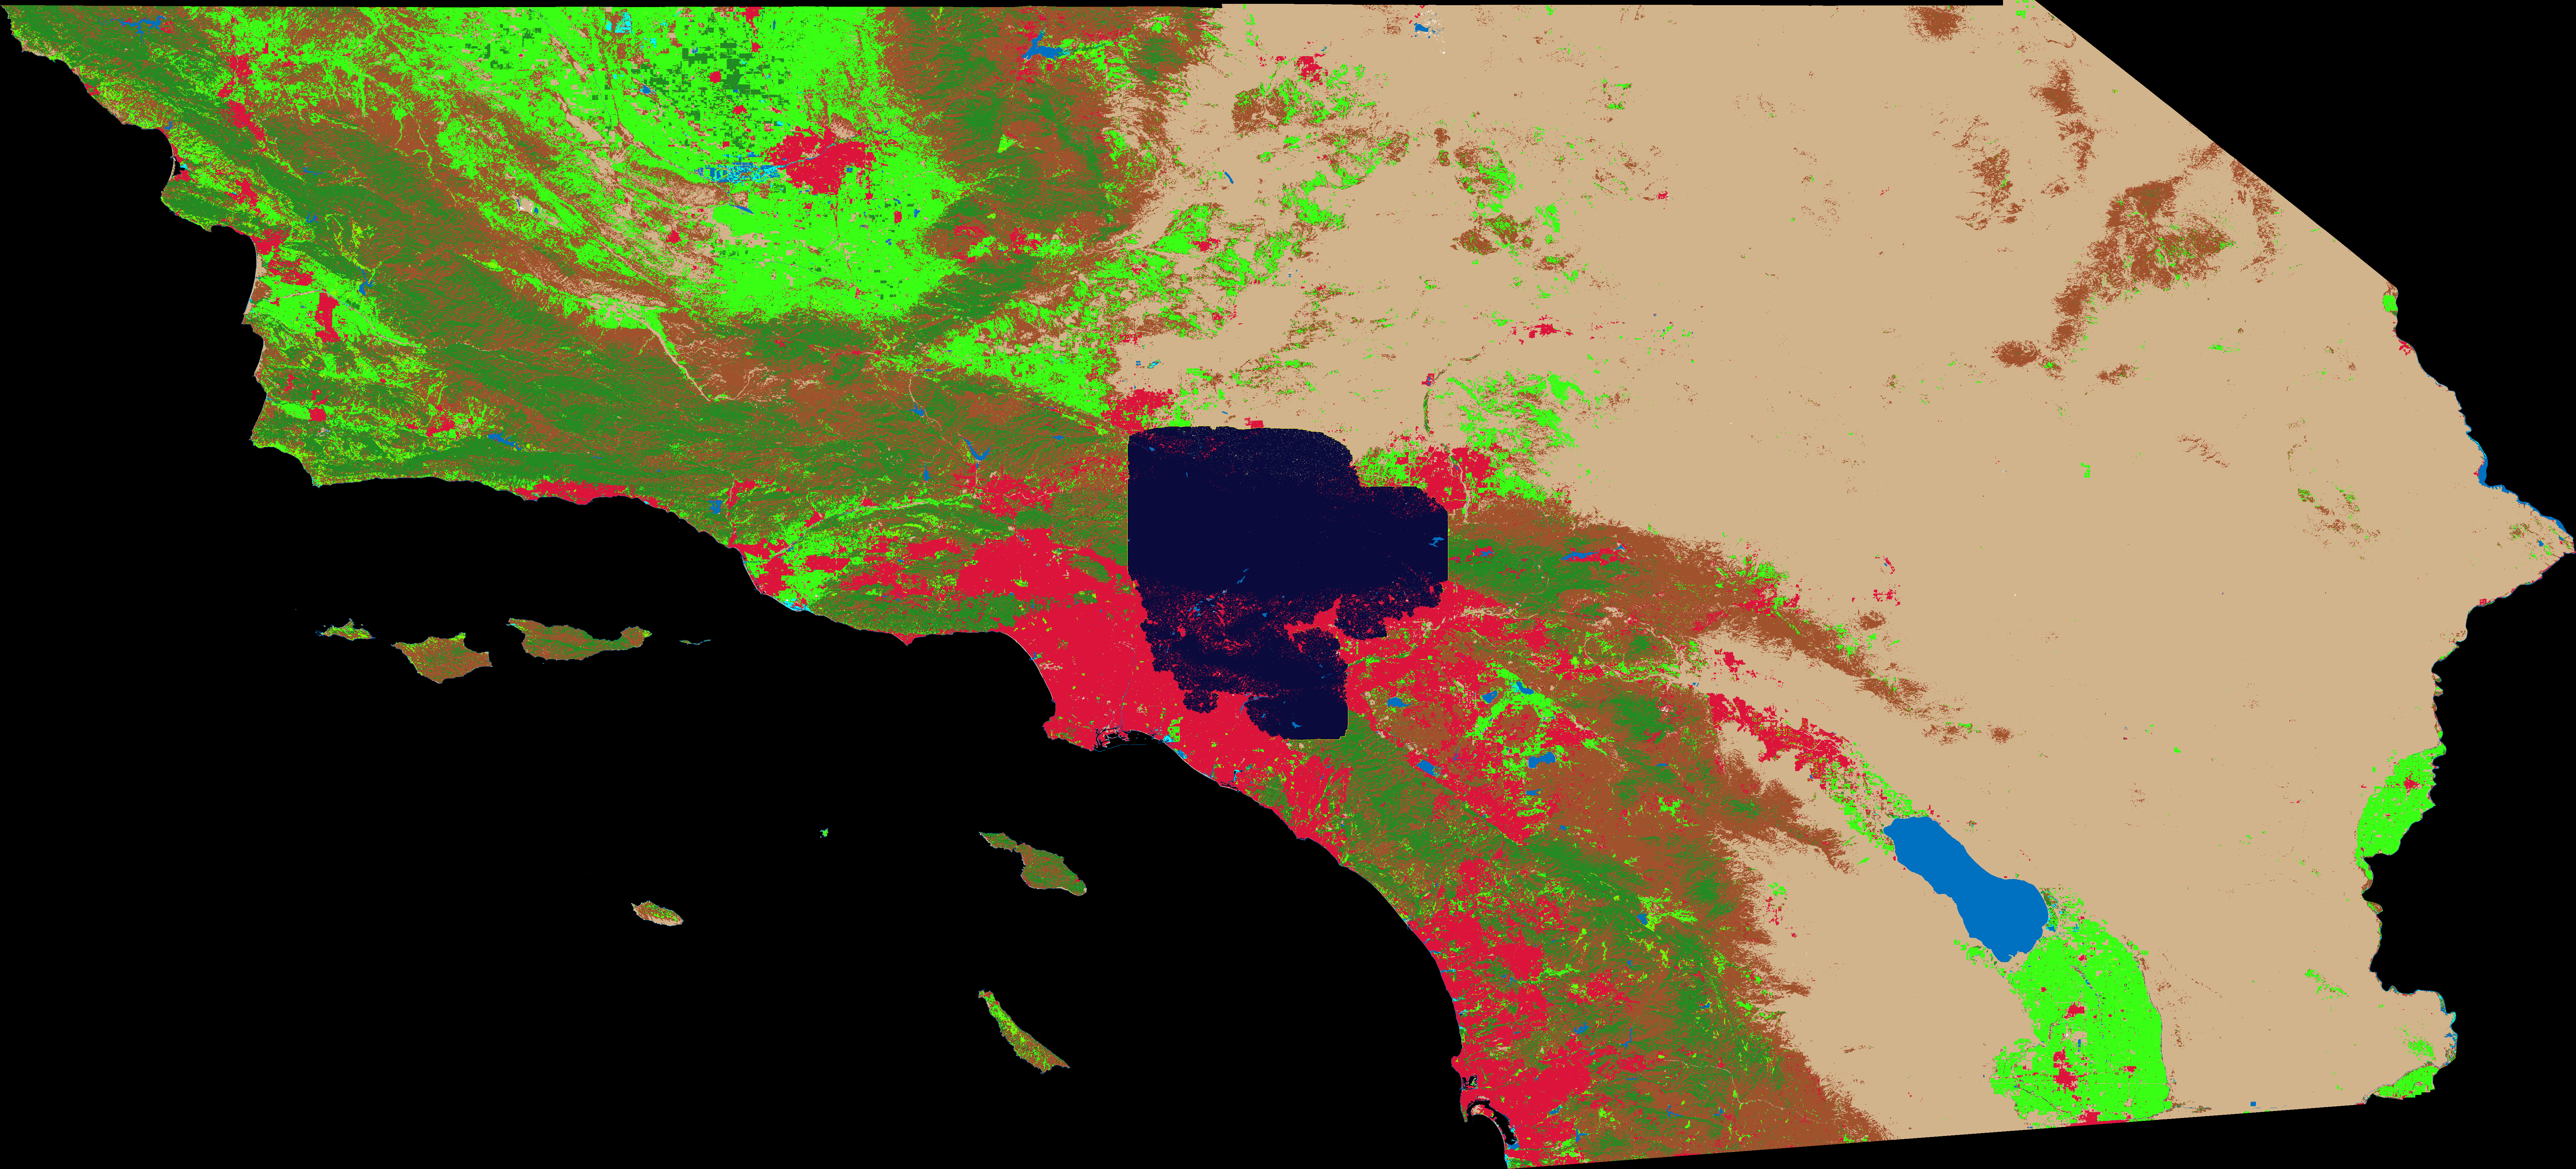

In [20]:
# === 1. Load the raster ===
with rasterio.open(os.path.join(path,"simraster500_.tif")) as src:
    land_use = src.read(1)  # Read first band only
    bounds = src.bounds
    
    land_use = np.where(land_use == -999, np.nan, land_use)

# === 2. Define land use classes and RGB colors ===
class_colors = {
    0: ('Water', (0, 112, 192)),
    1: ('Trees', (34, 139, 34)),
    2: ('Grass', (124, 252, 0)),
    3: ('Flooded Vegetation', (0, 255, 255)),
    4: ('Crops', (57, 255, 20)),
    5: ('Shrub and Scrub', (160, 82, 45)),
    6: ('Built', (220, 20, 60)),
    7: ('Bare', (210, 180, 140)),
    8: ('Snow and Ice', (255, 250, 250)),
    9: ('Burning', (255, 255, 0)),
    10: ('Burned', (10, 10, 60))
}

# === 3. Create an empty RGB image ===
height, width = land_use.shape
rgb = np.zeros((height, width, 3), dtype=np.uint8)

# === 4. Map class values to RGB channels ===
for class_val, (_, color) in class_colors.items():
    mask = (land_use == class_val)
    rgb[mask] = color  # This works since color is a 3-tuple (R, G, B)

# === 5. Create folium map ===
center = [(bounds.top + bounds.bottom) / 2, (bounds.left + bounds.right) / 2]
m = folium.Map(location=center, zoom_start=12, tiles='CartoDB positron')

img_overlay = ImageOverlay(
    image=rgb,
    bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
    opacity=0.6,
    name='Land Use',
)

img_overlay.add_to(m)
folium.LayerControl().add_to(m)

# === 6. Custom legend ===
legend_html = """
{% macro html(this, kwargs) %}
<div style="position: fixed;
     bottom: 20px; left: 20px; width: 200px; height: auto;
     z-index:9999; font-size:14px;
     background-color: white;
     border:2px solid grey; border-radius:6px;
     padding: 10px;">
<h4>Land Use Legend</h4>
<ul style="list-style: none; padding: 0; margin: 0;">
""" + "".join([
    f'<li><span style="background-color: rgb{rgb}; width: 12px; height: 12px; display: inline-block; margin-right: 8px;"></span>{label}</li>'
    for label, rgb in [class_colors[i] for i in sorted(class_colors)]
]) + """
</ul>
</div>
{% endmacro %}
"""

legend = MacroElement()
legend._template = Template(legend_html)
m.get_root().add_child(legend)

# === 7. Save the map ===
#m.save('land_use_map_with_legend.html')

m
